In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import os,sys
sys.path.append('../')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
import numpy as np
import itertools
import time
from scipy.special import eval_legendre
from scipy import interpolate
from scipy.special import spherical_jn
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [3]:
dirplots = '/home/dpirvu/dark-photon/code/examples/plots/'
dirdata = lambda mDP, om, nZs, nMs, lMax: '/home/dpirvu/dark-photon/code/examples/data/MA'+str(mDP)+'_omega0'+str(om)+'_nZs'+str(nZs)+'_nMs'+str(nMs)+'_ellMax'+str(lMax)


In [4]:
# From hmvec:
# r is always in Mpc
# k is always in Mpc-1
# All rho densities are in Msolar/Mpc^3
# All masses m are in Msolar
# No h units anywhere

MA = 10.**(-12.)        # Mass of dark photon
omega0 = 30*4.1e-6      # photon frequency today in eV

cmMpc = 3.24e-25               # Mpc/cm            # how many Mpc in a cm
eVinvCm = 1.24e-4              # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

msun = 1.9891e30     # kg                # Sun mass
mprot = 1.6e-27      # kg                # Proton mass
m2eV = 1.4e-21       # eV^2              # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2 = 0.02225                          # Physical baryon density parameter Ωb h2
omch2 = 0.1198                           # Physical dark matter density parameter Ωc h2
conv = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3

aa = lambda z: 1./(1.+z)
omegaz = lambda z: omega0/aa(z)

In [5]:
# Halo model parameters
nMasses = 500
nZs = 20
ellMax = 10000

############### HALO MODEL ###########################

# Create HALO MODEL
zs = np.linspace(0.01,4.,nZs)             # redshifts
ms = np.geomspace(1e7,1e17,nMasses)       # masses
ks = np.geomspace(1e-4,100,1001)          # wavenumbers
rs = np.linspace(1e-5,1e3,100000)         # halo radius
print('Creating Halo Model.')
hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

Creating Halo Model.


In [6]:
tau, num2h, CLdTau1h = np.load(dirdata(MA, omega0, nZs, nMasses, ellMax)+'_1hdata.npy')
CLhh, CLdTau2h = np.load(dirdata(MA, omega0, nZs, nMasses, ellMax)+'_2hdata.npy')
cellDeltaTau = CLdTau1h + CLdTau2h
 

#### Plot Dark Photon Signal Angular PS

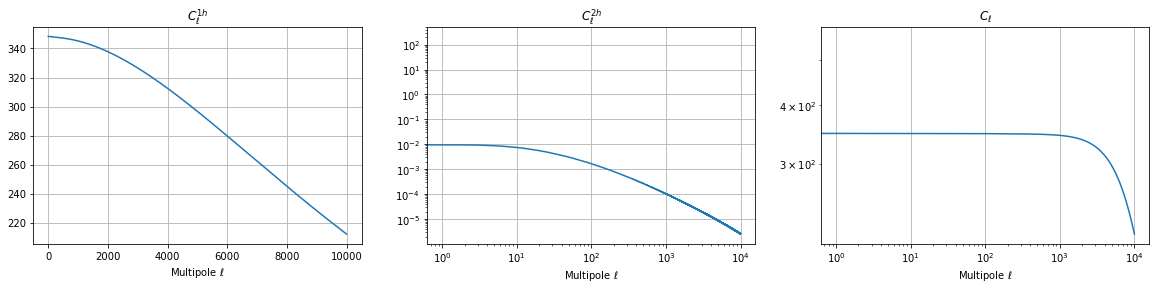

In [7]:
cmap = get_cmap(nZs+1)
#prefs = ells*(ells+1)/2./np.pi
prefs = 1.
ells = np.arange(ellMax)
label_list = [r'$C_\ell^{1h}(\chi)$',r'$C_\ell^{hh}(\chi,\chi)$',r'$C_\ell^{2h}(\chi,\chi)$']

cmap = get_cmap(nZs+1)
label_list = [r'$C_\ell^{1h}$',r'$C_\ell^{2h}$',r'$C_\ell$']
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
ax[0].plot(ells, prefs*CLdTau1h)
ax[1].loglog(ells, prefs*CLdTau2h)
ax[2].loglog(ells, prefs*cellDeltaTau)
for i, axis in enumerate(ax):
    axis.set_title(label_list[i])
    axis.set_xlabel(r'Multipole $\ell$')
    axis.grid()
plt.savefig(dirplots+'celltautau_terms_total.pdf')
plt.show()

In [9]:
np.shape(cellDeltaTau)

(10000,)

In [62]:
import scipy.special as ssp

#thetaList = np.linspace(0, np.pi/4., 500)
thetaList = np.linspace(0, 0.1, 100)
tauth = np.asarray([np.sum([np.sqrt(cellDeltaTau[ell])*(2.*ell+1.)*ssp.sph_harm(0, ell, 0, theta) for ell in range(ellMax)]) for theta in thetaList])

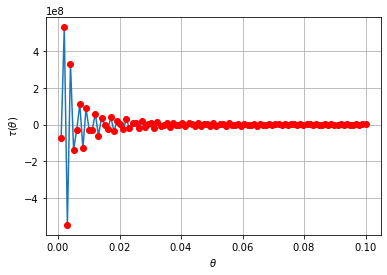

In [64]:
plt.plot(thetaList[1:], tauth.real[1:])
plt.plot(thetaList[1:], tauth.real[1:], 'ro')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\tau(\theta)$')
plt.grid(); plt.show()

372352316.14911515


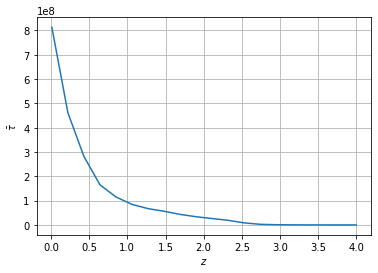

In [66]:
meantau = np.trapz(tau,zs); print(meantau)
plt.plot(zs, tau)
plt.ylabel(r'$\bar{\tau}$')
plt.xlabel(r'$z$')
#plt.yscale('log')
plt.grid(); plt.show()

In [9]:
if False:
    # two point correction function for optical depth
    angs = np.linspace(0, np.pi, 1000)
    Yellem = np.asarray([np.sqrt((2.*ell+1.)/4./np.pi)*eval_legendre(ell, np.cos(angs)) for ell in ells])
    taulm = np.sqrt(cellDeltaTau)
    deltatau = np.tensordot((2.*ells+1) * taulm, Yellem, axes=(0,0))

    taufull = meantau*(1.+deltatau)

    fig, ax = plt.subplots(1, 1, figsize=(25, 4))
    plt.plot(angs[:len(angs)//2][:100], taufull[:len(angs)//2][:100])
    plt.plot(angs[:len(angs)//2][:100], deltatau[:len(angs)//2][:100])
    plt.axhline(meantau, ls=':', color='darkgray')
    #plt.yscale('log')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\tau(\theta)$')
    plt.grid()

#### Compute New CMB PS with Dark Photon Signal

In [10]:
# CMB noise power spectra
def noise(ellsList):
    arcmin2rad = lambda a: a/60. * np.pi/180.
    thfwhm = arcmin2rad(1.) # beam FWHM
    mu = 10.*arcmin2rad(1.) # muK*arcmin
    NellTT = np.asarray([mu**2. * np.exp(ell*(ell+1)*thfwhm**2./8./np.log(2)) for ell in ellsList])
    return np.asarray([NellTT, np.sqrt(2.) * NellTT, np.sqrt(2.) * NellTT, np.zeros(len(ellsList))])

# Create CMB angular power spectra
powers = hcos.CMB_power_spectra()
unlensedCL = powers['unlensed_scalar']
unlensedCL = np.concatenate((unlensedCL,np.zeros((ellMax-2401,4))), axis=0)
lensedCL = powers['lensed_scalar']
lensedCL = np.concatenate((lensedCL,np.zeros((ellMax-2401,4))), axis=0)
noiseCL = noise(ells)

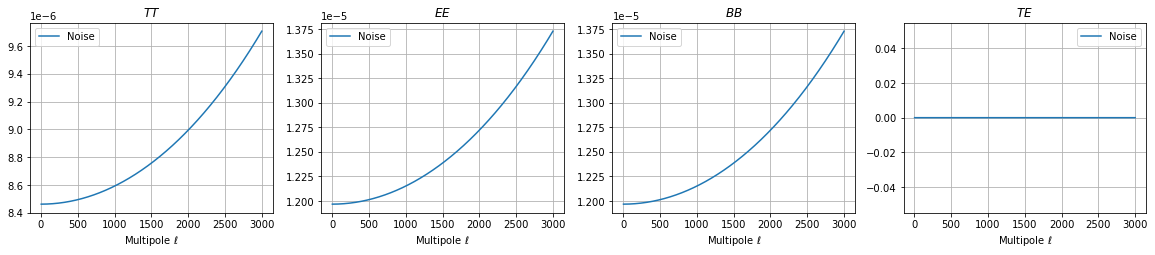

In [11]:
mm = 3
mmm = 3000

title_list = [r'$TT$', r'$EE$', r'$BB$', r'$TE$']
fig, ax = plt.subplots(1,4, figsize = (20,3.5))
ax[0].plot(ells[mm:mmm], noiseCL[0,mm:mmm], label=r'Noise')
ax[1].plot(ells[mm:mmm], noiseCL[1,mm:mmm], label=r'Noise')
ax[2].plot(ells[mm:mmm], noiseCL[2,mm:mmm], label=r'Noise')
ax[3].plot(ells[mm:mmm], noiseCL[3,mm:mmm], label=r'Noise')

for ai, ax in enumerate(ax.reshape(-1)):
    ax.set_title(title_list[ai])
    ax.set_xlabel(r'Multipole $\ell$')
    ax.legend(); ax.grid()
plt.show()

In [12]:
# Import angular PS for optical depth
list_ell2max = [500, 1000, 2000, 3000, 5000]
dell = 25
ellScrCl = np.arange(0, ellMax, dell) # multipole moments

#list_ell2max = [1000, 2400]
#list_ell2max = [6000]
#dell = 14
#ellstemp = np.arange(10, ellMax, dell) # multipole moments
#ellScrCl = np.asarray(np.arange(10).tolist()+ellstemp.tolist())
#print(len(ellScrCl), ellScrCl)

# We compute this numerically for sparse values of ell
ellsintp = ells[ells<=ellScrCl[-1]]
part_CMBDP = np.empty((len(list_ell2max),len(ellScrCl),4))
for lm,ell2max in enumerate(list_ell2max):
    part_CMBDP[lm] = np.load(dirdata(MA, omega0, nZs, nMasses, ellMax)+'_CMBDP_dell'+str(dell)+'_ell2max'+str(ell2max)+'.npy')
    
# We must interpolate $\delta\ell$ onto continuous multipole spectrum.
CMBDP = np.zeros((len(list_ell2max), len(ellsintp), 4))
for lm in range(len(list_ell2max)):
    for sp in range(4):
        f = interpolate.interp1d(ellScrCl, part_CMBDP[lm,::,sp], kind='linear')
        CMBDP[lm,::,sp] = f(ellsintp)   # use interpolation function returned by `interp1d`
print(np.shape(part_CMBDP), np.shape(CMBDP))


(5, 400, 4) (5, 9976, 4)


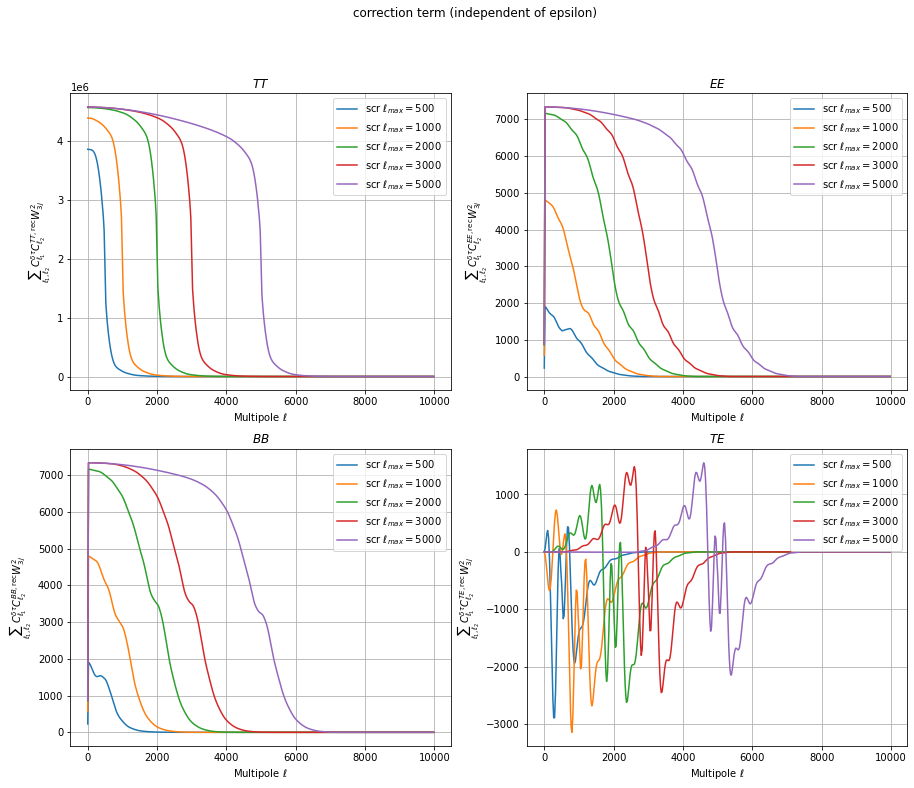

In [67]:
mm = 3
mmm = 10000

title_list = [r'$TT$', r'$EE$', r'$BB$', r'$TE$']
ylabel_list = [r'$\sum_{\ell_1,\ell_2} C_{\ell_1}^{\delta\tau} C_{\ell_2}^{TT, \mathrm{rec}} W^2_{3j}$',\
               r'$\sum_{\ell_1,\ell_2} C_{\ell_1}^{\delta\tau} C_{\ell_2}^{EE, \mathrm{rec}} W^2_{3j}$',\
               r'$\sum_{\ell_1,\ell_2} C_{\ell_1}^{\delta\tau} C_{\ell_2}^{BB, \mathrm{rec}} W^2_{3j}$',\
               r'$\sum_{\ell_1,\ell_2} C_{\ell_1}^{\delta\tau} C_{\ell_2}^{TE, \mathrm{rec}} W^2_{3j}$']
fig, ax = plt.subplots(2,2, figsize = (15,12))
for lm in range(len(list_ell2max)):
    ax[0,0].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[0,1].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,1], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,0].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,2], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,1].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,3], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))

for ai, ax in enumerate(ax.reshape(-1)):
    ax.set_title(title_list[ai])
#    ax.set_yscale('log')
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(ylabel_list[ai])
    ax.legend(); ax.grid()
plt.suptitle('correction term (independent of epsilon)')
plt.show()

392.7012406856488 0.014501512792521412 1.0788382001321506
13135.856500934955 21.099701113118655 0.0010788382001321506


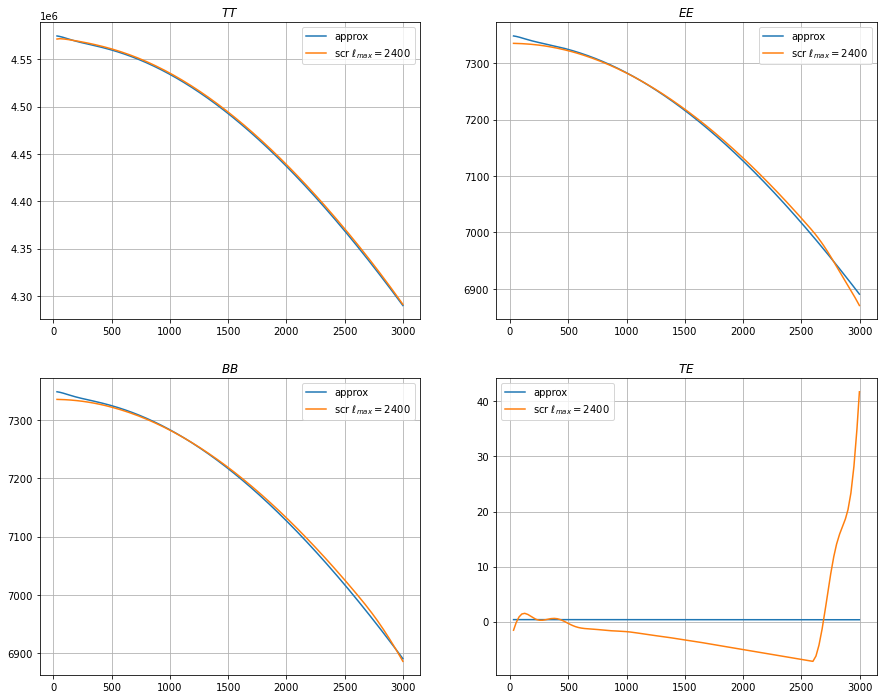

In [95]:
sumterm0 = np.sum([unlensedCL[ll,0]/(2.*ll+1.) for ll in range(2401)])
sumterm12 = np.sum([unlensedCL[ll,1]/(2.*ll+1.) for ll in range(2401)])
sumterm3 = np.sum([unlensedCL[ll,3]/(2.*ll+1.) for ll in range(2401)])
print(sumterm0, sumterm12, sumterm3)
sumterm0 = sumterm0*33.45
sumterm12 = sumterm12*1e3*1.455
sumterm3 = sumterm3*1e-3
print(sumterm0, sumterm12, sumterm3)

fig, ax = plt.subplots(2,2, figsize = (15,12))
ax[0,0].plot(ellsintp[mm:mmm], sumterm0*cellDeltaTau[mm:mmm], label=r'approx')
ax[0,1].plot(ellsintp[mm:mmm], sumterm12*cellDeltaTau[mm:mmm], label=r'approx')
ax[1,0].plot(ellsintp[mm:mmm], sumterm12*cellDeltaTau[mm:mmm], label=r'approx')
ax[1,1].plot(ellsintp[mm:mmm], sumterm3*cellDeltaTau[mm:mmm], label=r'approx')

if True:
    lm = -1
    ax[0,0].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[0,1].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,1], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,0].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,2], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,1].plot(ellsintp[mm:mmm], CMBDP[lm,mm:mmm,3], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))

title_list = [r'$TT$', r'$EE$', r'$BB$', r'$TE$']
for ai, ax in enumerate(ax.reshape(-1)):
    ax.set_title(title_list[ai])
    ax.legend(); ax.grid()
plt.show()

### Constraint on coupling constant

In [14]:
def ep4_sigma(epsilon4, tauav, ellm, CMBCl, mixedCl, noiseCl):
    tauep2 = tauav*np.sqrt(epsilon4)

    ClTTNl = (CMBCl[:,0] + tauep2**2. * mixedCl[:,0]) + noiseCl[0,:]
    ClEENl = (CMBCl[:,1] + tauep2**2. * mixedCl[:,1]) + noiseCl[1,:]
    ClBBNl = (CMBCl[:,2] + tauep2**2. * mixedCl[:,2]) + noiseCl[2,:]
    ClTENl = (CMBCl[:,3] + tauep2**2. * mixedCl[:,3]) + noiseCl[3,:]

    dClTTde4 = tauav**2. * mixedCl[:,0]
    dClEEde4 = tauav**2. * mixedCl[:,1]
    dClBBde4 = tauav**2. * mixedCl[:,2]
    dClTEde4 = tauav**2. * mixedCl[:,3]

    TrF = np.empty(ellm)
    for el in range(ellm):
        CCov = np.asarray([[ClTTNl[el], ClTENl[el], 0.        ],\
                           [ClTENl[el], ClEENl[el], 0.        ],\
                           [0.        , 0.        , ClBBNl[el]]])

        dCovde4 = np.asarray([[dClTTde4[el], dClTEde4[el], 0.          ],\
                              [dClTEde4[el], dClEEde4[el], 0.          ],\
                              [0.          , 0.          , dClBBde4[el]]])

        CCovInv = np.linalg.inv(CCov)
        TrF[el] = np.trace(CCovInv@dCovde4@CCovInv@dCovde4)

    CellList = np.asarray([0.5*(2.*ell+1.)*TrF[ell] for ell in range(2,ellm)])
    sigma = 1./np.sqrt(np.sum(CellList))
    return sigma

def ep_sigma(epsilon, tauav, ellm, CMBCl, mixedCl, noiseCl):
    tau2ep4 = (tauav*epsilon**2.)**2.

    ClTTNl = (CMBCl[:,0] + tau2ep4 * mixedCl[:,0]) + noiseCl[0,:]
    ClEENl = (CMBCl[:,1] + tau2ep4 * mixedCl[:,1]) + noiseCl[1,:]
    ClBBNl = (CMBCl[:,2] + tau2ep4 * mixedCl[:,2]) + noiseCl[2,:]
    ClTENl = (CMBCl[:,3] + tau2ep4 * mixedCl[:,3]) + noiseCl[3,:]

    dClTTde = 4.*tauav**2.*epsilon**3. * mixedCl[:,0]
    dClEEde = 4.*tauav**2.*epsilon**3. * mixedCl[:,1]
    dClBBde = 4.*tauav**2.*epsilon**3. * mixedCl[:,2]
    dClTEde = 4.*tauav**2.*epsilon**3. * mixedCl[:,3]

    TrF = np.empty(ellm)
    for el in range(ellm):
        CCov = np.asarray([[ClTTNl[el], ClTENl[el], 0.        ],\
                           [ClTENl[el], ClEENl[el], 0.        ],\
                           [0.        , 0.        , ClBBNl[el]]])

        dCovde = np.asarray([[dClTTde[el], dClTEde[el], 0.         ],\
                              [dClTEde[el], dClEEde[el], 0.         ],\
                              [0.         , 0.         , dClBBde[el]]])

        CCovInv = np.linalg.inv(CCov)
        TrF[el] = np.trace(CCovInv@dCovde@CCovInv@dCovde)

    CellList = np.asarray([0.5*(2.*ell+1.)*TrF[ell] for ell in range(2,ellm)])
    sigma = 1./np.sqrt(np.sum(CellList))
    return sigma

In [15]:
# Choose coupling
ep4List = np.geomspace(1e-35, 1e-20, 30)
sigmaList = np.empty((len(list_ell2max),len(ep4List)))
for lm in range(len(list_ell2max)):
    for ee, ep4 in enumerate(ep4List):
        sigmaList[lm,ee] = ep4_sigma(ep4, meantau, ellsintp[-1], unlensedCL[ellsintp], CMBDP[lm,ellsintp], noiseCL[:,ellsintp])

4 8.837020452015842e-09


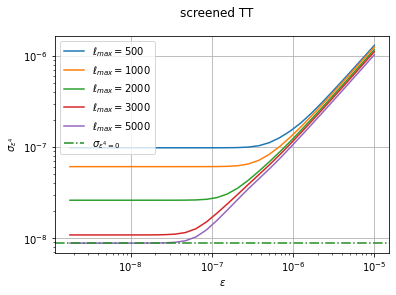

In [16]:
for lm in range(len(list_ell2max)):
    plt.plot(ep4List**0.25, sigmaList[lm]**0.25, label=r'$\ell_{max}=$'+str(list_ell2max[lm]))

sigmaFid = ep4_sigma(0, meantau, ellsintp[-1], unlensedCL[ellsintp], CMBDP[lm,ellsintp], noiseCL[:,ellsintp])
plt.axhline(sigmaFid**0.25, ls='-.', color='forestgreen', label=r'$\sigma_{\epsilon^4 = 0}$')
print(lm, sigmaFid**0.25)

plt.suptitle('screened TT')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_{\epsilon^4}$')
plt.xscale('log'); plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [17]:
# Choose coupling
epList = np.geomspace(1e-0, 1e-20, 30)
sigmaList = np.empty((len(list_ell2max),len(epList)))
for lm in range(len(list_ell2max)):
    for ee, ep in enumerate(epList):
        sigmaList[lm,ee] = ep_sigma(ep, meantau, ellsintp[-1], unlensedCL[ellsintp], CMBDP[lm,ellsintp], noiseCL[:,ellsintp])

/tmp/ipykernel_65627/1502498585.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  sigma = 1./np.sqrt(np.sum(CellList))


4 inf


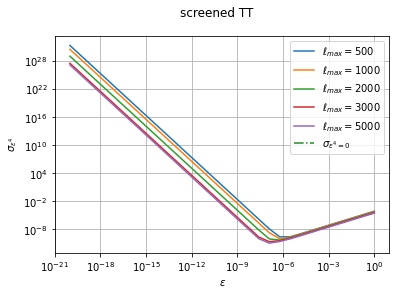

In [18]:
for lm in range(len(list_ell2max)):
    plt.plot(epList, sigmaList[lm], label=r'$\ell_{max}=$'+str(list_ell2max[lm]))

sigmaFid = ep_sigma(0, meantau, ellsintp[-1], unlensedCL[ellsintp], CMBDP[lm,ellsintp], noiseCL[:,ellsintp])
plt.axhline(sigmaFid, ls='-.', color='forestgreen', label=r'$\sigma_{\epsilon^4 = 0}$')
print(lm, sigmaFid)

plt.suptitle('screened TT')
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\sigma_{\epsilon^4}$')
plt.xscale('log'); plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

### Reconstruct full PS with screening

In [23]:
epsilon2 = 1e-15
print('Using value epsilon=', epsilon2)
tauep2 = meantau*epsilon2; print('mixing term prefactor', tauep2)
exptauep2 = np.exp(-2.*tauep2); print('neglect exponential:', exptauep2)
exptauep2 = 0.

Cltot = np.zeros(np.shape(CMBDP[:,:,:]))
print(np.shape(Cltot))
for lm in range(len(list_ell2max)):
    for ii in range(4):
        Cltot[lm,:,ii] = (unlensedCL[ellsintp,ii] + tauep2**2.*CMBDP[lm,:,ii])*np.exp(exptauep2) + noiseCL[ii,ellsintp]

Using value epsilon= 1e-15
mixing term prefactor 3.723523161491152e-07
neglect exponential: 0.999999255295645
(5, 9976, 4)


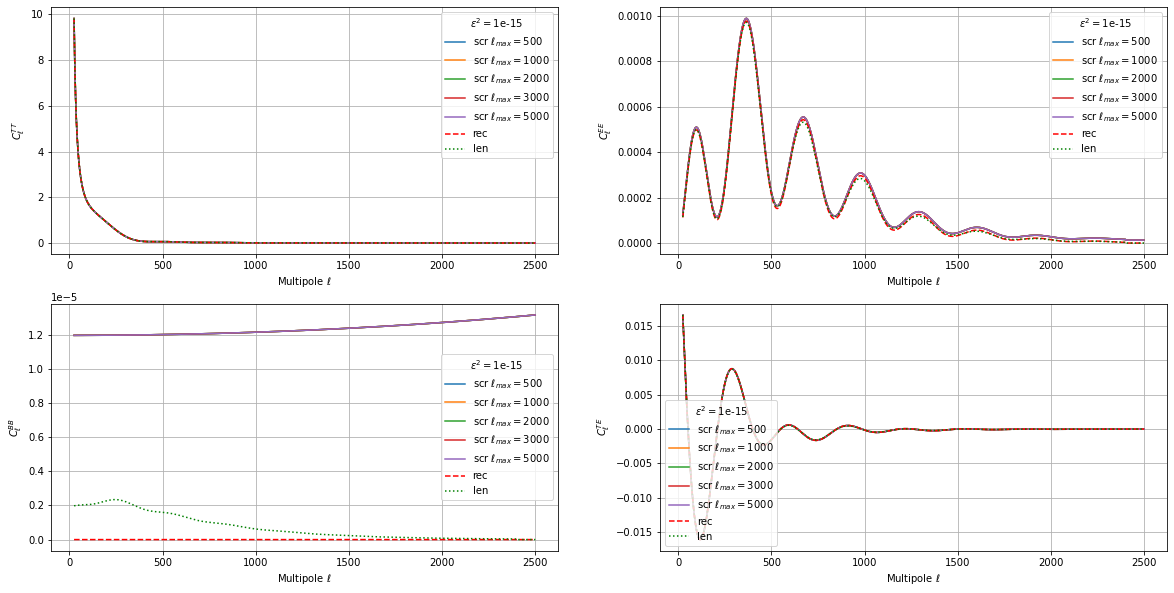

In [24]:
# Plot full screened CMB PS
mm = 25
mmm = 2500

ylabel_fullPS_list = [r'$C_\ell^{TT}$', r'$C_\ell^{EE}$', r'$C_\ell^{BB}$', r'$C_\ell^{TE}$']
fig, ax = plt.subplots(2,2, figsize = (20,10))
for lm in range(len(list_ell2max)):
    for ii in range(4):
        ax[np.divmod(ii,2)].plot(ells[mm:mmm], Cltot[lm,mm:mmm,ii], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))

for ii in range(4):
    ax[np.divmod(ii,2)].plot(ells[mm:mmm], unlensedCL[mm:mmm,ii], color='r', ls='--', label='rec')
    ax[np.divmod(ii,2)].plot(ells[mm:mmm], lensedCL[mm:mmm,ii], color='g', ls=':', label='len')

for ai, ax in enumerate(ax.reshape(-1)): 
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(ylabel_fullPS_list[ai])
    ax.legend(title=r'$\epsilon^2=$'+str(epsilon2)); ax.grid()
plt.savefig(dirplots+'PScomparison.pdf')

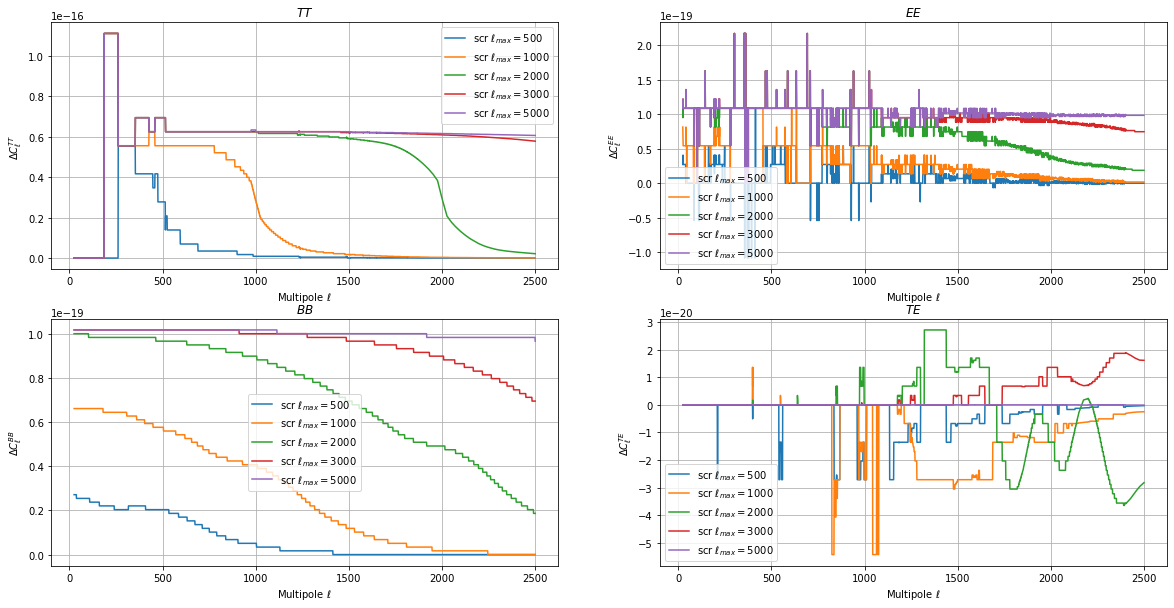

In [78]:
# Plot fractional difference of unlensed and screened spectra
ylabel_delta_list = [r'$\Delta C_\ell^{TT}$', r'$\Delta C_\ell^{EE}$', r'$\Delta C_\ell^{BB}$', r'$\Delta C_\ell^{TE}$']
fig, ax = plt.subplots(2,2, figsize = (20,10))
for lm in range(len(list_ell2max)):
    ax[0,0].plot(ells[mm:mmm], (Cltot[lm,mm:mmm,0]-noiseCL[0,mm:mmm])-unlensedCL[mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[0,1].plot(ells[mm:mmm], (Cltot[lm,mm:mmm,1]-noiseCL[1,mm:mmm])-unlensedCL[mm:mmm,1], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,0].plot(ells[mm:mmm], (Cltot[lm,mm:mmm,2]-noiseCL[2,mm:mmm])-unlensedCL[mm:mmm,2], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,1].plot(ells[mm:mmm], (Cltot[lm,mm:mmm,3]-noiseCL[3,mm:mmm])-unlensedCL[mm:mmm,3], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))

for ai, ax in enumerate(ax.reshape(-1)):
    ax.set_title(title_list[ai]);
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(ylabel_delta_list[ai])
    ax.grid(); ax.legend()
plt.savefig(dirplots+'PSconvperrec-1.pdf')

/tmp/ipykernel_65627/1080375976.py:5: RuntimeWarning: divide by zero encountered in divide
  ax[0,0].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,0]-noiseCL[0,mm:mmm])/unlensedCL[mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
/tmp/ipykernel_65627/1080375976.py:6: RuntimeWarning: divide by zero encountered in divide
  ax[0,1].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,1]-noiseCL[1,mm:mmm])/unlensedCL[mm:mmm,1], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
/tmp/ipykernel_65627/1080375976.py:8: RuntimeWarning: divide by zero encountered in divide
  ax[1,1].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,3]-noiseCL[3,mm:mmm])/unlensedCL[mm:mmm,3], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
/tmp/ipykernel_65627/1080375976.py:5: RuntimeWarning: divide by zero encountered in divide
  ax[0,0].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,0]-noiseCL[0,mm:mmm])/unlensedCL[mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
/tmp/ipykernel_65627/1080375976.py:6: RuntimeWarning: divide by 

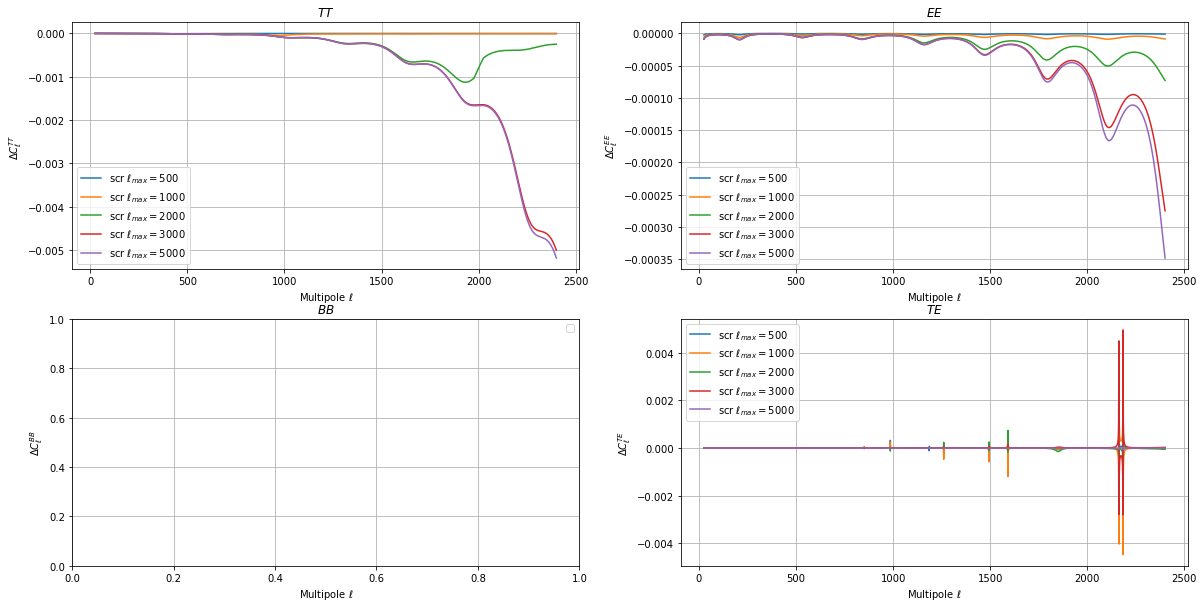

In [25]:
# Plot fractional difference of unlensed and screened spectra
ylabel_delta_list = [r'$\Delta C_\ell^{TT}$', r'$\Delta C_\ell^{EE}$', r'$\Delta C_\ell^{BB}$', r'$\Delta C_\ell^{TE}$']
fig, ax = plt.subplots(2,2, figsize = (20,10))
for lm in range(len(list_ell2max)):
    ax[0,0].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,0]-noiseCL[0,mm:mmm])/unlensedCL[mm:mmm,0], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[0,1].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,1]-noiseCL[1,mm:mmm])/unlensedCL[mm:mmm,1], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
#    ax[1,0].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,2]-noiseCL[2,mm:mmm])/unlensedCL[mm:mmm,2], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))
    ax[1,1].plot(ells[mm:mmm], 1.-(Cltot[lm,mm:mmm,3]-noiseCL[3,mm:mmm])/unlensedCL[mm:mmm,3], label=r'scr $\ell_{max}=$'+str(list_ell2max[lm]))

for ai, ax in enumerate(ax.reshape(-1)):
    ax.set_title(title_list[ai]);
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(ylabel_delta_list[ai])
    ax.grid(); ax.legend()
plt.savefig(dirplots+'PSconvperrec-1.pdf')

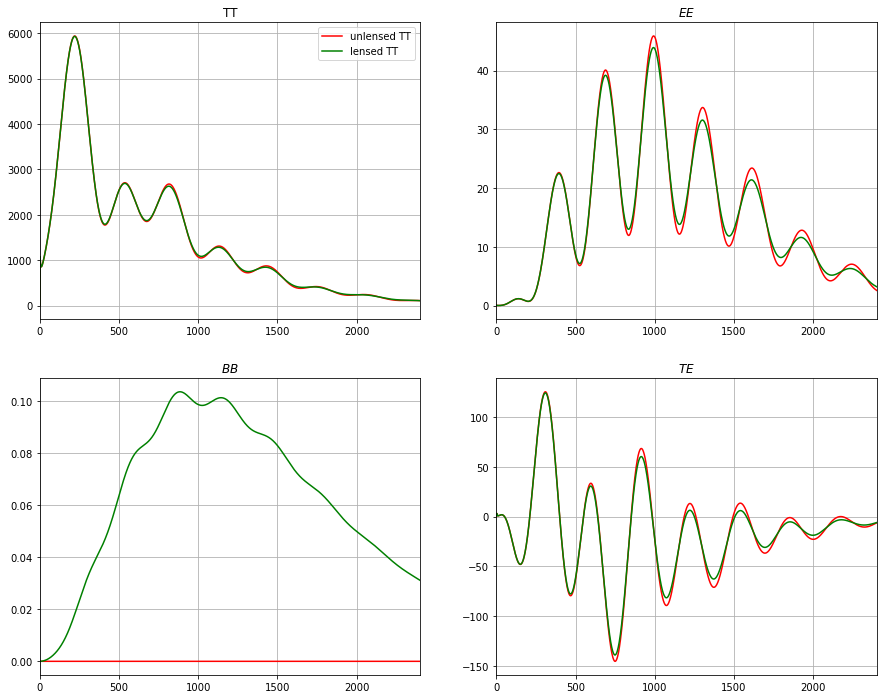

In [22]:
if True:
    #plot the total lensed CMB power spectra versus unlensed
    unled = unlensedCL[:2401]
    ledt = lensedCL[:2401]

    ls = np.arange(ledt.shape[0])
    sc = ls*(ls+1)/2./np.pi

    #Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    #The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
    fig, ax = plt.subplots(2,2, figsize = (15,12))
    ax[0,0].plot(ls, sc*unled[:,0], color='r', label='unlensed TT')
    ax[0,0].plot(ls, sc*ledt[:,0], color='g', label='lensed TT')
    ax[0,0].set_title('TT'); ax[0,0].legend()

    ax[0,1].plot(ls, sc*unled[:,1], color='r', label='unlensed EE')
    ax[0,1].plot(ls, sc*ledt[:,1], color='g', label='lensed EE')
    ax[0,1].set_title(r'$EE$'); ax[0,0].legend()

    ax[1,0].plot(ls, sc*unled[:,2], color='r', label='unlensed BB')
    ax[1,0].plot(ls, sc*ledt[:,2], color='g')
    ax[1,0].set_title(r'$BB$'); ax[0,0].legend()

    ax[1,1].plot(ls, sc*unled[:,3], color='r', label='unlensed TE')
    ax[1,1].plot(ls, sc*ledt[:,3], color='g')
    ax[1,1].set_title(r'$TE$'); ax[0,0].legend()
    for ax in ax.reshape(-1): ax.set_xlim([0,ls[-1]]); ax.grid()